In [2]:
import numpy as np
import pandas as pd
from main import PredictChurn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pc = PredictChurn(check_validation=True)
df_results_train, df_results_test = pc.train_model_and_predict()

churn
0    7164
1    1836
Name: count, dtype: int64
churn
0    815
1    185
Name: count, dtype: int64
Train AUC: 0.668
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      7164
           1       0.29      0.62      0.40      1836

    accuracy                           0.62      9000
   macro avg       0.58      0.62      0.56      9000
weighted avg       0.75      0.62      0.65      9000

Test AUC: 0.6429116232797215
              precision    recall  f1-score   support

           0       0.87      0.62      0.72       815
           1       0.26      0.58      0.36       185

    accuracy                           0.61      1000
   macro avg       0.56      0.60      0.54      1000
weighted avg       0.75      0.61      0.65      1000



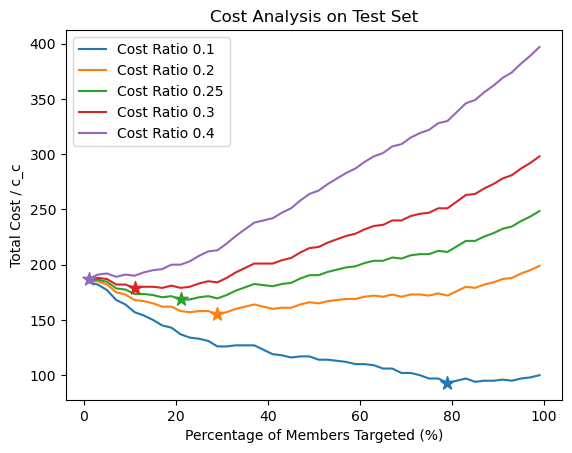

In [4]:

def calculate_cost_analysis(df_results, perfect_results_simulation=True, cost_ratios=[0.1, 0.2, 0.25, 0.3, 0.4]):
    df_results = df_results.copy()
    if perfect_results_simulation:
        df_results['prioritization_score'] = df_results['true']
    ratios_results = {ratio: [] for ratio in cost_ratios}

    df_results.sort_values(by='prioritization_score', ascending=False, inplace=True)

    percentages = np.arange(1,100,2)
    for percent in percentages:
        n = int(len(df_results)*percent/100)
        df_results_at_k = df_results.head(n)
        df_results_at_k['prioritization_score'] = 1 

        fn = df_results['true'].sum() - df_results_at_k['true'].sum() # all the positives not captured in top k
        for ratio in cost_ratios:
            # Total Cost / c_c = ( n * c_o + fn * c_c ) / c_c
            # print(f"Ratio: {ratio}, n: {n}, fn: {fn}, Total Cost / c_c: {n * ratio + fn}")
            norm_cost = n * ratio + fn
            ratios_results[ratio].append(norm_cost)
    min_percent = {ratio: (percentages[np.argmin(ratios_results[ratio])], np.min(ratios_results[ratio])) for ratio in cost_ratios}
    return ratios_results, min_percent

def plot_cost_analysis(ratios_results, min_percent):
    for ratio, costs in ratios_results.items():
        plt.plot(np.arange(1,100,2), costs, label=f'Cost Ratio {ratio}')
        plt.scatter(min_percent[ratio][0], min_percent[ratio][1], marker='*', s=100, zorder=5) # Use a star marker

    plt.xlabel('Percentage of Members Targeted (%)')
    plt.ylabel('Total Cost / c_c')
    plt.title('Cost Analysis on Test Set')
    plt.legend()
    plt.show()

ratios_results, min_percent = calculate_cost_analysis(df_results_test, perfect_results_simulation=False)
plot_cost_analysis(ratios_results, min_percent)

In [3]:
pc = PredictChurn(check_validation=False)
df_results_train, df_results_test = pc.train_model_and_predict(top_percentage=0.29)

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 71ee72ae-d01d-41d2-8930-cd8f5cb1f355)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002524813F080>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: e8a940b0-7663-4f14-b8e0-36a67262859c)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6

In [5]:
min_percent[0.2]

(29, 155.0)

# Read data

In [2]:
df_usage = pd.read_csv('train/app_usage.csv') # pd.read_csv('test/test_app_usage.csv') 
df_visits = pd.read_csv('train/web_visits.csv')
df_claims = pd.read_csv('train/claims.csv')
df_churn_labels = pd.read_csv('train/churn_labels.csv')

In [ ]:
import random
random.seed(42)
members = list(set(df_visits['member_id'].unique().tolist() + df_claims['member_id'].unique().tolist() + df_usage['member_id'].unique().tolist()))
train_size = int(0.9 * len(members))
train_members = random.sample(members, train_size)

def split_data(df, train_members):
    df_train = df[df['member_id'].isin(train_members)]
    df_test = df[~df['member_id'].isin(train_members)]
    return df_train, df_test

df_visits_train, df_visits_test = split_data(df_visits, train_members)
df_usage_train, df_usage_test = split_data(df_usage, train_members)
df_claims_train, df_claims_test = split_data(df_claims, train_members)
df_churn_labels_train, df_churn_labels_test = split_data(df_churn_labels, train_members)

print(df_churn_labels_train['churn'].value_counts())
print(df_churn_labels_test['churn'].value_counts())

churn
0    7161
1    1839
Name: count, dtype: int64
churn
0    818
1    182
Name: count, dtype: int64


In [ ]:
import importlib
import preprocess_data
importlib.reload(preprocess_data)
from preprocess_data import PreprocessData

train_preprocessor = PreprocessData(df_usage=df_usage_train, df_visits=df_visits_train, df_claims=df_claims_train, df_churn_labels=df_churn_labels_train)
df_train = train_preprocessor.join_data()

test_preprocessor = PreprocessData(df_usage=df_usage_test, df_visits=df_visits_test, df_claims=df_claims_test, df_churn_labels=df_churn_labels_test)
df_test = test_preprocessor.join_data()

df_train.drop(columns=['outreach','signup_date'], inplace=True)
df_test.drop(columns=['outreach','signup_date'], inplace=True)

In [131]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report

# X_train, y_train = df_train.drop(columns=['member_id', 'churn']), df_train['churn']
# X_test, y_test = df_test.drop(columns=['member_id', 'churn']), df_test['churn']

X_train, y_train = df_train_scaled.drop(columns=['member_id', 'churn']), df_train_scaled['churn']
X_test, y_test = df_test_scaled.drop(columns=['member_id', 'churn']), df_test_scaled['churn']

# scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])  # ~4
# model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,max_depth=1, learning_rate=0.2, n_estimators=50, objective='binary:logistic') # 0.66

# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(penalty="l2",C=0.2, class_weight="balanced",solver="lbfgs",max_iter=1000) # 0.654

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf=30,max_features=0.5,class_weight="balanced_subsample",random_state=42)

# from catboost import CatBoostClassifier
# model = CatBoostClassifier(iterations=300, depth=4, learning_rate=0.1,loss_function="Logloss",eval_metric="AUC", class_weights=[1, 4], verbose=False)

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred_proba = model.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print(f"Train AUC: {auc_train:.3f}")
print(classification_report(y_train, (y_train_pred_proba > 0.5).astype(int)))

auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc:.3f}")
print(classification_report(y_test, (y_pred_proba > 0.5).astype(int)))

Train AUC: 0.670
              precision    recall  f1-score   support

           0       0.86      0.61      0.71      7161
           1       0.29      0.62      0.39      1839

    accuracy                           0.61      9000
   macro avg       0.58      0.61      0.55      9000
weighted avg       0.75      0.61      0.65      9000

Test AUC: 0.631
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       818
           1       0.23      0.58      0.33       182

    accuracy                           0.58      1000
   macro avg       0.55      0.58      0.51      1000
weighted avg       0.75      0.58      0.63      1000



In [13]:
df_results_train = pd.DataFrame({'pred':y_train_pred_proba, 'true':y_train}).sort_values(by='pred', ascending=False)
df_results_test = pd.DataFrame({'pred':y_pred_proba, 'true':y_test}).sort_values(by='pred', ascending=False)

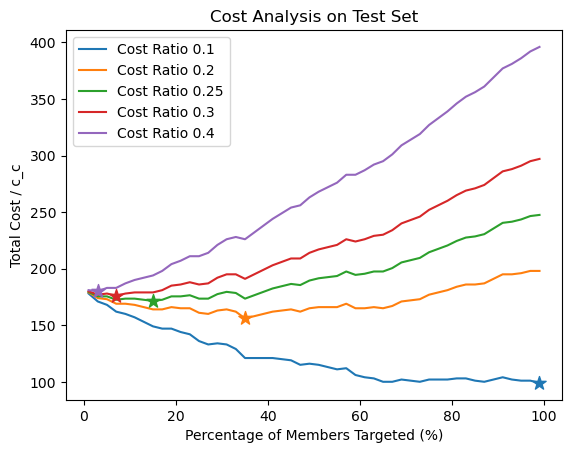

In [126]:
plot_cost_analysis(ratios_results, min_percent)

In [15]:
df_train_scaled.isna().sum()

member_id           0
visit_emb_0_mean    0
visit_emb_0_std     0
visit_emb_1_mean    0
visit_emb_1_std     0
                   ..
icd_code_J00        0
icd_code_K21.9      0
icd_code_M54.5      0
icd_code_R51        0
icd_code_Z71.3      0
Length: 103, dtype: int64

In [10]:
df_test_scaled.head()

,member_id,visit_emb_0_mean,visit_emb_0_std,visit_emb_1_mean,visit_emb_1_std,visit_emb_2_mean,visit_emb_2_std,visit_emb_3_mean,visit_emb_3_std,visit_emb_4_mean,...,icd_code_A09,icd_code_B34.9,icd_code_E11.9,icd_code_H10.9,icd_code_I10,icd_code_J00,icd_code_K21.9,icd_code_M54.5,icd_code_R51,icd_code_Z71.3
0,6,1.081600,0.424895,1.093612,-0.025662,-0.093014,0.527838,0.789145,0.584685,-0.476029,...,-0.731707,-0.736971,-0.937107,-0.732444,2.177740,-0.726036,-0.723558,-0.736638,0.629842,1.119019
1,8,0.073457,0.312634,-0.913969,1.108234,-0.124353,0.280288,0.138371,-0.235507,-0.502797,...,-0.731707,0.615727,0.112527,-0.732444,-0.939018,-0.726036,0.649444,0.630889,-0.716729,0.093702
2,11,-1.200485,-0.883334,-0.824067,-0.357645,0.096134,-0.898156,-0.754891,0.113685,-0.100004,...,-0.731707,0.615727,-0.937107,0.623505,1.138821,0.638343,-0.723558,-0.736638,-0.716729,2.144336
3,12,-1.180027,0.127391,-2.471387,-1.018451,-0.136206,-1.239354,-0.546026,2.011988,-0.095304,...,-0.731707,-0.736971,0.112527,0.623505,3.216660,-0.726036,2.022445,0.630889,0.629842,1.119019
4,14,0.320009,0.677276,0.997780,-0.123329,-0.563240,0.572810,0.560236,-0.166539,-0.931374,...,-0.731707,0.615727,0.112527,-0.732444,0.099901,-0.726036,-0.723558,-0.736638,0.629842,1.119019


In [11]:
df_train_scaled.head(10)

,member_id,visit_emb_0_mean,visit_emb_0_std,visit_emb_1_mean,visit_emb_1_std,visit_emb_2_mean,visit_emb_2_std,visit_emb_3_mean,visit_emb_3_std,visit_emb_4_mean,...,icd_code_A09,icd_code_B34.9,icd_code_E11.9,icd_code_H10.9,icd_code_I10,icd_code_J00,icd_code_K21.9,icd_code_M54.5,icd_code_R51,icd_code_Z71.3
0,1,1.692293,1.669573,2.984411,-1.235908,1.044287,-1.827437,1.736378,-0.225085,-4.581249,...,-0.731707,-0.736971,0.112527,-0.732444,0.099901,4.731481,-0.723558,0.630889,-0.716729,1.119019
1,2,2.831603,-1.658762,0.786376,1.265758,-1.800966,1.098574,2.722798,-2.242910,-1.251338,...,-0.731707,-0.736971,2.211793,-0.732444,1.138821,-0.726036,0.649444,-0.736638,0.629842,1.119019
2,3,0.327618,-0.022262,-0.510065,0.671624,-0.985787,0.581576,0.539424,0.351344,0.161675,...,-0.731707,-0.736971,0.112527,-0.732444,-0.939018,-0.726036,0.649444,1.998417,-0.716729,-0.931615
3,4,0.337523,-0.698516,0.390905,0.091267,-2.029202,1.497705,0.696507,-0.146216,-0.596955,...,0.613499,-0.736971,-0.937107,-0.732444,2.177740,0.638343,-0.723558,-0.736638,-0.716729,-0.931615
4,5,0.292237,0.063175,-0.528543,1.818782,-1.032134,1.616783,0.672389,-0.090673,0.177689,...,-0.731707,-0.736971,1.162160,-0.732444,0.099901,-0.726036,0.649444,1.998417,-0.716729,0.093702
5,7,-0.730448,-0.516991,-0.509404,-0.207966,0.379980,-0.906724,-0.596751,-0.006361,-0.964295,...,-0.731707,-0.736971,0.112527,-0.732444,-0.939018,0.638343,-0.723558,-0.736638,-0.716729,0.093702
6,9,-0.533802,-0.699480,0.354679,-0.876043,-1.775961,-0.107172,-0.067889,-0.902663,0.948983,...,-0.731707,-0.736971,0.112527,1.979455,1.138821,0.638343,-0.723558,0.630889,-0.716729,-0.931615
7,10,-0.020937,-0.462759,0.028976,0.637889,-0.911786,0.630842,-0.029438,0.009761,0.300968,...,-0.731707,-0.736971,2.211793,-0.732444,0.099901,0.638343,0.649444,-0.736638,-0.716729,0.093702
8,13,-1.123397,0.217685,0.190685,-0.824656,1.386809,-1.012995,-0.962735,0.202718,-0.131104,...,0.613499,1.968425,0.112527,-0.732444,0.099901,0.638343,0.649444,0.630889,-0.716729,-0.931615
9,15,0.947284,0.257469,0.460523,0.684292,0.696306,-0.981617,0.724977,-0.002367,-0.854979,...,-0.731707,-0.736971,0.112527,-0.732444,0.099901,-0.726036,-0.723558,1.998417,-0.716729,1.119019


In [23]:
df_claims.head()

,member_id,icd_code,diagnosis_date
0,1,Z71.3,2025-07-09
1,1,Z71.3,2025-07-14
2,1,J00,2025-07-12
3,1,M54.5,2025-07-01
4,1,I10,2025-07-12


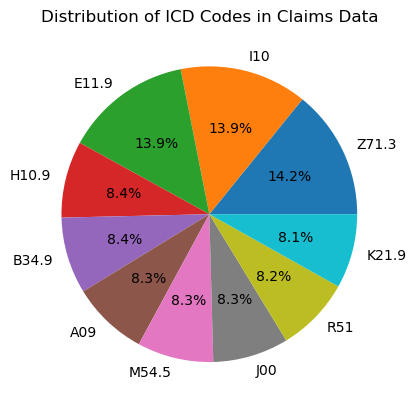

In [22]:

labels = df_claims['icd_code'].value_counts().index
plt.pie(df_claims['icd_code'].value_counts(), labels=labels, autopct='%1.1f%%');
plt.title('Distribution of ICD Codes in Claims Data')
plt.show()

In [39]:
df_churn_labels

,member_id,signup_date,churn,outreach
0,1,2024-04-12,0,0
1,2,2025-03-11,0,0
2,3,2024-09-27,0,0
3,4,2024-04-16,1,0
4,5,2024-03-12,0,1
...,...,...,...,...
9995,9996,2024-09-02,0,0
9996,9997,2024-02-07,0,0
9997,9998,2024-09-01,0,0
9998,9999,2024-01-21,0,0


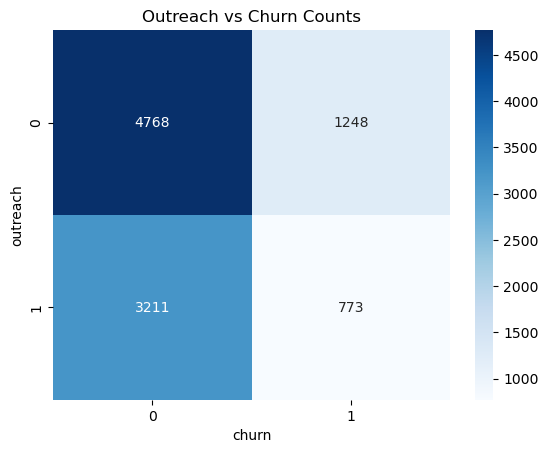

In [51]:
import seaborn as sns

corr = np.corrcoef(df_churn_labels['outreach'], df_churn_labels['churn'])[0, 1]
corr

crosstab = pd.crosstab(df_churn_labels['outreach'], df_churn_labels['churn'])
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Outreach vs Churn Counts')
plt.show()

In [60]:
corr_outreach_churn = np.corrcoef(df_churn_labels['churn'], df_churn_labels['outreach'])[0, 1]
print(f"Correlation between Outreach and Churn: {corr_outreach_churn:.3f}")

Correlation between Outreach and Churn: -0.016


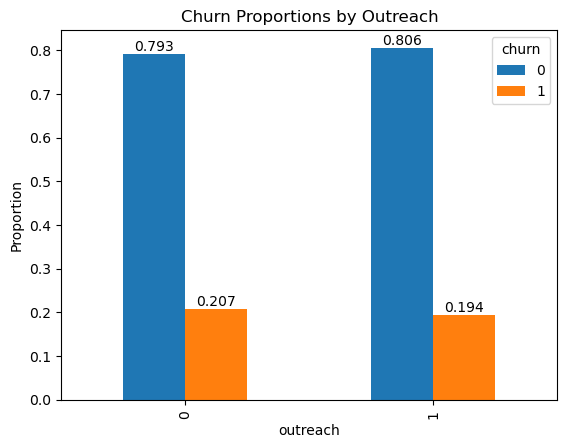

In [70]:
outreach_churn = df_churn_labels.groupby('outreach')['churn'].value_counts(normalize=True).unstack()
ax = outreach_churn.plot(kind='bar', stacked=False)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.title('Churn Proportions by Outreach')
plt.ylabel('Proportion')
plt.show()